1) Развернуть у себя на компьютере/виртуальной машине/хостинге MongoDB и реализовать функцию, записывающую собранные вакансии в созданную БД

2) Написать функцию, которая производит поиск и выводит на экран вакансии с заработной платой больше введенной суммы

3)*Написать функцию, которая будет добавлять в вашу базу данных только новые вакансии с сайта. Доработать функцию, которая будет обновлять старые вакансии.

**Здесь укажем искомую вакансию**

In [83]:
VAC_NAME = 'Менеджер по продукту'

**Основной алгоритм**

In [84]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
import lxml as lxml
import numpy as np
import pandas as pd
import re
from pymongo import MongoClient

*MongoDB*

In [85]:
def get_job_opening_db():
    
    client = MongoClient('mongodb://127.0.0.1:27017')
    db = client['job_opening_db']
    
    return db

In [86]:
def fill_job_opening_db(job_db, vacant_list):
    
    docs = job_db.docs

    result = docs.insert_many(vacant_list)
    return result
   

In [87]:
def clear_job_opening_db(job_db, filter_):
    
    docs = job_db.docs
    docs.delete_many(filter_)
    

In [88]:
def update_existing_job_opening_db(job_db, vacant_list):
    
    for record in vacant_list:
        rec_rev = job_db.docs.find_one({'url': record['url']})
        
        #Проверим что изменилась или что это новая запись
        if not rec_rev: #Новая запись
            job_db.docs.insert_one(record)
            print('Новая запись:')
            pprint(record)
        else: #возможно изменилась
            del rec_rev['_id']
            if '_id' in record: del record['_id']
                        
            if rec_rev != record:
       
                print('Измененная запись:')
                pprint(rec_rev)
                
                job_db.docs.update_one({'url' : record['url']}, {"$set":record})
        #break

In [89]:
def filter_job_opening(job_db, filter_):
    
    docs = job_db.docs
    result = list(docs.find(filter_))
    
    return result

*HH.ru*

In [90]:
def get_vacancy_HH(vacant_list, vacansy_name):
    
    VAC_NAME = vacansy_name.replace(' ', '+')
    SOURCE_HH = 'https://hh.ru'
    MAIN_LINK = 'https://hh.ru/search/vacancy?st=searchVacancy&L_profession_id=4.1&area=1&no_magic=true'
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
    url = MAIN_LINK + '&text=' + VAC_NAME
    
    next_url = url

    while next_url != '':

        response = requests.get(next_url, headers = header)

        if response.ok:


            html = BeautifulSoup(response.text, 'lxml')
            vacs = html.find_all("div", attrs={ "data-qa" : "vacancy-serp__vacancy"})

            for vac in vacs:
                list_el = {}

                #general info
                tags = vac.find("a", attrs = {"class" : "bloko-link HH-LinkModifier"})
                list_el['url'] = tags['href']
                list_el['caption'] = tags.text
                list_el['sourse'] = 'hh.ru'

                #краткое описание
                descr_path = vac.find('div', attrs = {'data-qa':'vacancy-serp__vacancy_snippet_responsibility'})
                list_el['description'] = descr_path.text

                #salary info
                list_el['salary_from'] = 'n/a'
                list_el['salary_to'] = 'n/a'
                list_el['currensy'] = 'n/a'
                list_el['salary_max'] = 0

                salary_path = vac.find("div", attrs = {"class" : "vacancy-serp-item__compensation"})

                if salary_path: #зарплата указана

                    salary_text = salary_path.text

                    list_el['currensy'] = salary_text.split(' ')[-1][:3]

                    if salary_text[:2] == 'от': #указана только минимальная зп
                        list_el['salary_from'] = salary_text.split(' ')[1].replace('\xa0','')
                    else:
                        if salary_text[:2] == 'до':#указана только максимальная зп
                            list_el['salary_from'] = salary_text.split(' ')[1].replace('\xa0','')
                        else: #указана вилка
                            list_el['salary_from'] = salary_text.split(' ')[0].split('-')[0].replace('\xa0','')
                            list_el['salary_to'] = salary_text.split(' ')[0].split('-')[1].replace('\xa0','')
                            
                if list_el['salary_from'].isdigit(): list_el['salary_max'] = int(list_el['salary_from'])
                if list_el['salary_to'].isdigit(): list_el['salary_max'] = int(list_el['salary_to'])
                
                #инфо о городе
                city_path = vac.find("span", attrs = {"data-qa":"vacancy-serp__vacancy-address"})

                if city_path:
                    list_el['city'] = city_path.text

                #инфо о работодателе
                employer_path = vac.find("a", attrs = {"data-qa":"vacancy-serp__vacancy-employer"})

                list_el['employer_url'] = 'n/a'
                list_el['employer'] = 'n/a'

                if employer_path:
                    list_el['employer_url'] = SOURCE_HH + employer_path['href']
                    list_el['employer'] = employer_path.text

                vacant_list.append(list_el)

        else:
            print(response)
            break

        next_url = ''

        next_url_path = html.find("a", {"class":"bloko-button HH-Pager-Controls-Next HH-Pager-Control"})

        if next_url_path:
            next_url = SOURCE_HH + next_url_path['href']


*SuperJob.ru*

In [91]:
def get_vacancy_SJ(vacant_list, vacansy_name):
    
    VAC_NAME = vacansy_name.replace(' ', '+')
    SOURCE_SJ = 'https://superjob.ru'
    MAIN_LINK = 'https://superjob.ru/vacancy/search/'
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
    
    url = MAIN_LINK + '?keywords=' + VAC_NAME
    
    next_url = url
    
    while next_url != '':
    
        response = requests.get(next_url, headers = header)

        if response.ok:

            html = BeautifulSoup(response.text, 'lxml')
            vacs = html.find_all("div", {"class" : "_3zucV _2GPIV f-test-vacancy-item i6-sc _3VcZr"})

            for vac in vacs:

                list_el = {}

                general_path = vac.find('div', {"class","_3mfro CuJz5 PlM3e _2JVkc _3LJqf"})
                descr_path = vac.find('div', {"class","_2kyiZ _1cFsi _3VUIu"})
                salary_path = vac.find('span', {"class","_3mfro _2Wp8I f-test-text-company-item-salary PlM3e _2JVkc _2VHxz"})
                city_path = vac.find('span', {"_3mfro f-test-text-company-item-location _9fXTd _2JVkc _2VHxz"})
                employer_path = vac.find('span', {"_3mfro _3Fsn4 f-test-text-vacancy-item-company-name _9fXTd _2JVkc _2VHxz _15msI"})

                #general info
                list_el['url'] = SOURCE_SJ + general_path.parent['href']
                list_el['caption'] = general_path.text
                list_el['sourse'] = SOURCE_SJ

                #краткое описание
                list_el['description'] = descr_path.find('span', {'class':'_3mfro _9fXTd _2JVkc _2VHxz _15msI'}).text

                #salary info
                list_el['salary_from'] = salary_path.text
                list_el['salary_to'] = 'n/a'
                list_el['currensy'] = 'n/a'
                list_el['salary_max'] = 0

                if salary_path: #зарплата указана

                    salary_text = salary_path.text

                    if salary_text != 'По договорённости':

                        list_el['currensy'] = salary_text.split('\xa0')[-1][:1]

                        if salary_text[:2] == 'от': #указана только минимальная зп
                            list_el['salary_from'] = salary_text.split('\xa0')[1] + salary_text.split('\xa0')[2]
                        else:
                            if salary_text[:2] == 'до':#указана только максимальная зп
                                list_el['salary_from'] = salary_text.split('\xa0')[1] + salary_text.split('\xa0')[2]
                                list_el['salary_max'] = int(list_el['salary_from'])
                            else: #указана вилка или точная зп
                                list_el['salary_from'] = salary_text.split('\xa0')[0] + salary_text.split('\xa0')[1]

                                if len(salary_text.split('\xa0')) > 4:
                                    list_el['salary_to'] = salary_text.split('\xa0')[3] + salary_text.split('\xa0')[4]
                                if list_el['salary_to'].isdigit(): list_el['salary_max'] = int(list_el['salary_to'])
                #инфо о городе
                list_el['city'] = city_path.text.split(' • ')[1]

                #инфо о работодателе
                list_el['employer_url'] = 'n/a'
                list_el['employer'] = 'n/a'

                if employer_path:
                    short_emp = employer_path.find('a', {'class':re.compile('icMQ_ _205Zx.*')})
                    list_el['employer_url'] = SOURCE_SJ + short_emp['href']
                    list_el['employer'] = short_emp.text

                vacant_list.append(list_el)

        else:
            print(response)
            break

        next_url = ''

        next_url_path_list = html.find_all("span", {"class":"qTHqo _2h9me DYJ1Y _2FQ5q _2GT-y"})
        next_url_path = next_url_path_list[-1]         
        if next_url_path.text == 'Дальше':
            next_url = SOURCE_SJ + next_url_path.parent['href']

*Поиск вакансий*

In [92]:
vacant_list = list()

get_vacancy_HH(vacant_list, VAC_NAME)
get_vacancy_SJ(vacant_list, VAC_NAME)

*Обработка результата*

In [93]:
df = pd.DataFrame(vacant_list)

In [94]:
df['salary_from_n'] = df['salary_from']
df['salary_to_n'] = df['salary_to']

In [95]:
df.loc[(df['salary_from_n'] == 'n/a') | (df['salary_from_n'] == 'По договорённости'), 'salary_from_n'] = '0'
df.loc[(df['salary_to_n'] == 'n/a') | (df['salary_from_n'] == 'По договорённости'), 'salary_to_n'] = '0'

In [96]:
df['salary_from_n'].apply(lambda x: int(x))
df['salary_to_n'].apply(lambda x: int(x))

df['salary_max'] = df[['salary_from_n','salary_to_n']].max(axis =1)

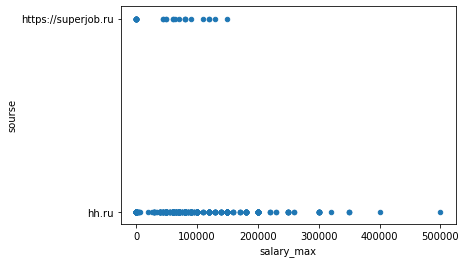

In [97]:
df.plot.scatter('salary_max', 'sourse')

In [98]:
df

,url,caption,sourse,description,salary_from,salary_to,currensy,salary_max,city,employer_url,employer,salary_from_n,salary_to_n
0,https://tver.hh.ru/vacancy/34843375?query=%D0%...,Менеджер продукта,hh.ru,"Сбор и анализ требований к продуктам, а также ...",200000,n/a,руб,200000.0,Москва,https://hh.ru/employer/1978012,ООО ВижнЛабс (VisionLabs),200000,0
1,https://tver.hh.ru/vacancy/35737991?query=%D0%...,Менеджер по продукту,hh.ru,"Поддержка продаж продукта ""Стойловое оборудова...",n/a,n/a,n/a,0.0,"Москва, Отрадное",https://hh.ru/employer/137377,ООО ГЕА Рефрижерейшн РУС,0,0
2,https://tver.hh.ru/vacancy/31427685?query=%D0%...,Менеджер по продукту (мобильные телефоны),hh.ru,Общение с производителем по всем вопросам: мар...,100000,200000,руб,200000.0,"Москва, Речной вокзал",https://hh.ru/employer/539668,VVP Group,100000,200000
3,https://tver.hh.ru/vacancy/35669393?query=%D0%...,Продакт-менеджер,hh.ru,"Создание, запуск на рынок и последующее управл...",200000,n/a,руб,200000.0,"Москва, Площадь Гагарина и еще 1",https://hh.ru/employer/3067218,ООО Антал-М,200000,0
4,https://tver.hh.ru/vacancy/35720879?query=%D0%...,Менеджер по продукту (Product manager),hh.ru,Участвовать в определении и реализации стратег...,180000,n/a,руб,180000.0,Москва,https://hh.ru/employer/2536,SPN,180000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,https://superjob.ru/vakansii/prodakt-menedzher...,Продакт-менеджер,https://superjob.ru,Должностные обязанности: Управление ассортимен...,По договорённости,n/a,n/a,0.0,"Москва,Ботанический сад",https://superjob.ru/clients/briz-klimaticheski...,Бриз-Климатические системы,0,0
1524,https://superjob.ru/vakansii/prodakt-menedzher...,Продакт-менеджер,https://superjob.ru,"Должностные обязанности: Разработка , расчёт и...",60000,n/a,₽,60000.0,Москва,https://superjob.ru/clients/zoogurman-381214.html,ЗООГУРМАН,60000,0
1525,https://superjob.ru/vakansii/mladshij-prodakt-...,Младший продакт-менеджер (м. Планерная),https://superjob.ru,Должностные обязанности: Анализ рынка вентиляц...,45000,n/a,₽,45000.0,"Москва,Планерная",https://superjob.ru/clients/zern-blauberg-grou...,"ООО ""ЗЕРН"" BLAUBERG Group",45000,0
1526,https://superjob.ru/vakansii/prodakt-menedzher...,Продакт-менеджер в фармацевтическую компанию,https://superjob.ru,Должностные обязанности: Подготовка целевых пр...,По договорённости,n/a,n/a,0.0,"Москва,Таганская, Марксистская",https://superjob.ru/clients/brend-farm-165929....,Бренд-Фарм,0,0


**Запись в MongoDB**

In [99]:
db = get_job_opening_db()

In [100]:
clear_job_opening_db(db, {'sourse':'hh.ru'})
clear_job_opening_db(db, {'sourse':'https://superjob.ru'})

In [101]:
result = fill_job_opening_db(db, vacant_list)
result

In [102]:
#добавим и изменим запись для примера
#что-то изменилось еще и на сайтах
vacant_list.append({'url':'new____.ru', 'comment': 'добавленная запись'})
vacant_list[0]['caption'] = 'Измененное название должности'
update_existing_job_opening_db(db, vacant_list)

Измененная запись:
{'caption': 'Менеджер продукта',
 'city': 'Москва',
 'currensy': 'руб',
 'description': 'Сбор и анализ требований к продуктам, а также потребностей, '
                'от внутренних и внешних заказчиков. - Анализ потенциальных и '
                'текущих рынков наших...',
 'employer': 'ООО ВижнЛабс (VisionLabs)',
 'employer_url': 'https://hh.ru/employer/1978012',
 'salary_from': '200000',
 'salary_max': 200000,
 'salary_to': 'n/a',
 'sourse': 'hh.ru',
 'url': 'https://tver.hh.ru/vacancy/34843375?query=%D0%9C%D0%B5%D0%BD%D0%B5%D0%B4%D0%B6%D0%B5%D1%80%20%D0%BF%D0%BE%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82%D1%83'}
Новая запись:
{'_id': ObjectId('5e4155d6face7c4208975bd3'),
 'comment': 'добавленная запись',
 'url': 'new____.ru'}


In [103]:
result = filter_job_opening(db, {'salary_max': {'$gt': 20000}})

for record in result:
    pprint(record)

{'_id': ObjectId('5e4155d5face7c42089755db'),
 'caption': 'Измененное название должности',
 'city': 'Москва',
 'currensy': 'руб',
 'description': 'Сбор и анализ требований к продуктам, а также потребностей, '
                'от внутренних и внешних заказчиков. - Анализ потенциальных и '
                'текущих рынков наших...',
 'employer': 'ООО ВижнЛабс (VisionLabs)',
 'employer_url': 'https://hh.ru/employer/1978012',
 'salary_from': '200000',
 'salary_max': 200000,
 'salary_to': 'n/a',
 'sourse': 'hh.ru',
 'url': 'https://tver.hh.ru/vacancy/34843375?query=%D0%9C%D0%B5%D0%BD%D0%B5%D0%B4%D0%B6%D0%B5%D1%80%20%D0%BF%D0%BE%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82%D1%83'}
{'_id': ObjectId('5e4155d5face7c42089755dd'),
 'caption': 'Менеджер по продукту (мобильные телефоны)',
 'city': 'Москва, Речной вокзал',
 'currensy': 'руб',
 'description': 'Общение с производителем по всем вопросам: маркетинг, продажи '
                'и т д. Координация поставок мобильных телефонов. Управление '
